# Reducing QAOA Circuit Depth by Factoring out Semi-Symmetries

## References
1. https://arxiv.org/abs/2411.08824
2. https://arxiv.org/abs/2412.17841

In [1]:
import numpy as np
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import networkx as nx

## Load Moderna instance

In [2]:
path = "seq_1033_c.lp"
mod = Model()
mod = ModelReader.read_model(path)

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
cost_operator, offset = qubo.to_ising()

# convert QP to a upper triangular QUBO matrix
Q = qubo.objective.quadratic.to_array(symmetric=False)
Q += np.identity(Q.shape[0])*qubo.objective.linear.to_array()
print(Q.shape)
#print(qubo.export_as_lp_string())

(100, 100)


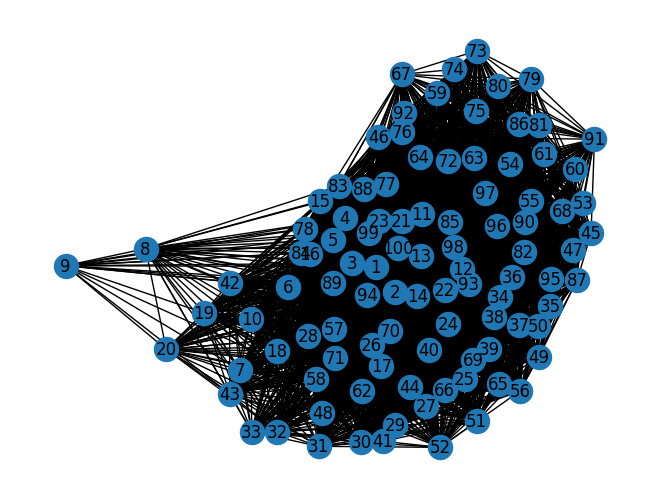

In [3]:
N, M = Q.shape
edges = []
for i in range(N):
    for j in range(i+1, M):
        if Q[i, j] > 0:
            edges.append((i+1, j+1))
G = nx.Graph(edges)
np.random.seed(0)
nx.draw(G, with_labels=True)

## Modules for factoring out semi-symmetries

Modules used "Algorithm 1 Factoring out Semi-Symmetries":

In [4]:
def get_conflict_list(Q):
    cL = []
    n = Q.shape[0]
    Z = [sum([Q[i, j] for j in range(n) if Q[i, j] < 0])for i in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if Q[i, j] > - Z[i] - Z[j]:
                cL.append((i, j))
    return cL


def get_most_symmetric_qubits(Q, cL):
    n = Q.shape[0]
    best = (0, 1)
    bestSyms = []
    for (i, j) in cL: # i < j in cL
        syms = [k for k in range(n) if Q[min(i, k), max(i, k)] == Q[min(j, k), max(j, k)] != 0]
        #print(i, j, len(syms))
        if len(syms) >= len(bestSyms):
            best = (i, j)
            bestSyms = syms
    return bestSyms, best


def enhance(Q, i, j, syms, z):
    n = Q.shape[0]
    Q_mod = np.zeros((n+1, n+1))
    Q_mod[:n, :n] = np.triu(Q)
    Q_mod[i, i] += z
    Q_mod[j, j] += z
    Q_mod[n, n] = z
    Q_mod[i, n] = -2 * z
    Q_mod[j, n] = -2 * z
    Q_mod[i, j] = 2 * z
    for k in syms:
        Q_mod[k, n] = Q[min(i, k), max(i, k)]
        Q_mod[min(i, k), max(i, k)] = 0
        Q_mod[min(j, k), max(j, k)] = 0
    return Q_mod


def factoring_out_semi_symmetries(Q, num_ancillas=1, z=3):
    cL = get_conflict_list(Q)
    n = Q.shape[0]
    n_new = n
    while len(cL) > 0:
        syms, (i, j) = get_most_symmetric_qubits(Q, cL)
        if len(syms) < 3 or n_new == n + num_ancillas:
            break
        Q = enhance(Q, i, j, syms, z)
        n_new += 1
        cL = get_conflict_list(Q)
    return Q

`num_ancillas` is the number of ancilla qubits ($x_a$) to be added, and `z` is a positive penalty value. If we choose $z = \sum_{(i, j)} |Q_{i,j}|$ at least, valid solutions $x$ have the same energy regarding $Q$ as to $Q_{\text{mod}}$ with best values for the ancilla qubits $x_{\text{mod}} = x + [x_a]$.

In [5]:
Q_mod = factoring_out_semi_symmetries(Q, num_ancillas=10, z=np.sum(np.abs(Q)))
Q_mod.shape

(110, 110)

In [6]:
N = Q.shape[0]
density = np.count_nonzero(np.triu(Q)) / (N+N*(N-1)//2) * 100
print(f"Density (original): {density:.3f}%")

N_mod = Q_mod.shape[0]
density_mod = np.count_nonzero(np.triu(Q_mod)) / (N_mod+N_mod*(N_mod-1)//2) * 100
print(f"Density (mod): {density_mod:.3f}%")

Density (original): 75.109%
Density (mod): 48.141%


In [7]:
def convert_Q2op(Q):
    qubo = QuadraticProgram()
    n = Q.shape[0]
    for i in range(n):
        qubo.binary_var(f'x{i}')
    linear = {}
    quadratic = {}
    for i in range(n):
        for j in range(i, n):
            if i == j:
                linear[f"x{i}"] = Q[i, i]
            else:
                quadratic[f"x{i}", f"x{j}"] = Q[i, j]
    qubo.minimize(linear=linear, quadratic=quadratic)
    qubit_op, offset = qubo.to_ising()
    return qubo, qubit_op, offset

In [8]:
qubo_mod, cost_operator_mod, offset_mod = convert_Q2op(Q_mod)

## Optimize QUBO

Let us skip this section since it takes long time.

In [9]:
#cplex_result = CplexOptimizer().solve(qubo)
#print(cplex_result.prettyprint())

In [10]:
#cplex_result.x

In [11]:
#cplex_result_mod = CplexOptimizer().solve(qubo_mod)
#print(cplex_result_mod.prettyprint())

In [12]:
#cplex_result_mod.x

In [13]:
#np.all(cplex_result_mod.x[:Q.shape[0]] == cplex_result.x)

## Transpile QAOA circuit

### Original QUBO

In [14]:
num_qubits = Q.shape[0]
# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

qaoa_layers = 2

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

In [15]:
service = QiskitRuntimeService(instance="client-enablement/its/its-skill-buildi")
backend = service.backend('ibm_torino')

In [16]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0)
qaoa = pm.run(qaoa_ansatz)

### Modified QUBO

In [17]:
num_qubits = Q_mod.shape[0]
# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

qaoa_layers = 2

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz_mod = QAOAAnsatz(
    cost_operator_mod,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz_mod.measure_all()

## Comparison

In [18]:
qaoa_mod = pm.run(qaoa_ansatz_mod)

In [19]:
qaoa.count_ops()

OrderedDict([('sx', 97908),
             ('cz', 52368),
             ('rz', 49510),
             ('x', 157),
             ('measure', 100),
             ('barrier', 1)])

In [20]:
qaoa.depth()

25248

In [21]:
qaoa_mod.count_ops()

OrderedDict([('sx', 80149),
             ('cz', 42468),
             ('rz', 38859),
             ('x', 128),
             ('measure', 110),
             ('barrier', 1)])

In [22]:
qaoa_mod.depth()

21272

# Optimal QAOA Transpiler

In [23]:
from optimal_qaoa_transpile import run_optimal_qaoa_transpiler

In [24]:
num_qubits = len(cost_operator[0].paulis[0])
num_qubits_mod =  len(cost_operator_mod[0].paulis[0])
print(num_qubits, num_qubits_mod)

100 110


In [25]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(max(num_qubits, num_qubits_mod))
print(path, fidelity)

[3, 2, 1, 0, 15, 19, 20, 21, 34, 40, 39, 38, 53, 57, 58, 59, 72, 78, 77, 76, 91, 95, 96, 97, 110, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 113, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 92, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 75, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 54, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 37, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 16, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 0.0


In [26]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0, initial_layout=path[:num_qubits])
qaoa = pm.run(qaoa_ansatz)

In [27]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=0, initial_layout=path[:num_qubits_mod])
qaoa_mod = pm.run(qaoa_ansatz_mod)

In [28]:
qaoa.depth(), qaoa_mod.depth()

(25184, 22517)

In [29]:
backend.configuration().supported_instructions

['cz',
 'id',
 'delay',
 'measure',
 'reset',
 'rz',
 'sx',
 'x',
 'if_else',
 'for_loop',
 'switch_case',
 'rx',
 'rzz']

In [30]:
basis_gates = ["x", "cx", "sx", "rz", "id"]
qaoa_opt = run_optimal_qaoa_transpiler(num_qubits, qaoa_layers, cost_operator, path[:num_qubits], backend, basis_gates=basis_gates)
qaoa_mod_opt = run_optimal_qaoa_transpiler(num_qubits_mod, qaoa_layers, cost_operator_mod, path[:num_qubits_mod], backend, basis_gates=basis_gates)

In [31]:
qaoa_opt.depth(), qaoa_mod_opt.depth()

(1188, 1074)

In [32]:
qaoa.count_ops()

OrderedDict([('sx', 101111),
             ('cz', 53444),
             ('rz', 49976),
             ('x', 194),
             ('measure', 100),
             ('barrier', 1)])

In [33]:
qaoa_opt.count_ops()

OrderedDict([('cx', 14772),
             ('rz', 7586),
             ('rx', 200),
             ('h', 100),
             ('measure', 100)])

In [34]:
qaoa_mod.count_ops()

OrderedDict([('sx', 84202),
             ('cz', 44512),
             ('rz', 38763),
             ('x', 181),
             ('measure', 110),
             ('barrier', 1)])

In [35]:
qaoa_mod_opt.count_ops()

OrderedDict([('cx', 11316),
             ('rz', 5876),
             ('rx', 220),
             ('h', 110),
             ('measure', 110)])

In [36]:
basis_gates = ["x", "cx", "sx", "rz", "id", "rzz"]
qaoa_opt = run_optimal_qaoa_transpiler(num_qubits, qaoa_layers, cost_operator, path[:num_qubits], backend, basis_gates=basis_gates)
qaoa_mod_opt = run_optimal_qaoa_transpiler(num_qubits_mod, qaoa_layers, cost_operator_mod, path[:num_qubits_mod], backend, basis_gates=basis_gates)

In [37]:
qaoa_opt.depth(), qaoa_mod_opt.depth()

(400, 362)

In [38]:
qaoa_opt.count_ops()

OrderedDict([('rzz', 7386),
             ('rz', 200),
             ('rx', 200),
             ('h', 100),
             ('measure', 100)])

In [39]:
qaoa_mod_opt.count_ops()

OrderedDict([('rzz', 5658),
             ('rx', 220),
             ('rz', 218),
             ('h', 110),
             ('measure', 110)])